# Реализация k-means с помощью numpy+matplotlib. Некоторые исследования алгоритма и его модификации.

## Глава 1, в которой появляется реализация k-means.

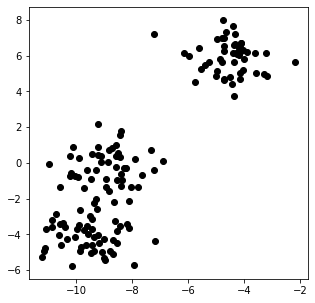

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
%matplotlib inline

#определим значение seed для воспроизводимости результатов
seed = 1984

#создадим датасет и выберем число кластеров
data, true_labels = make_blobs(n_samples=150, n_features=2,
                         centers=3, random_state=seed)
k = 3

#нарисуем датасет
fig = plt.figure(figsize=(5, 5))
plt.scatter(data[:,0], data[:,1], color='k')
plt.show()

#определим цвета для кластеров
colors = {1: 'r', 2: 'g', 3: 'b'}

#### Словесное описание алгоритма по шагам:
1. Инициализация – выберем как-то(случайно или по определенному алгоритму) k центроидов.
2. Распределение – для каждой точки из набора определим кластер, в зависимости от того, к какому центроиду она ближе.
3. Пересчёт – пересчитаем центроиды для каждого кластера.
4. Повторяем шаги 2,3 пока решение не сойдется.
5. На выходе имеем набор из k центроидов и набор точек, распределенных по k кластерам.

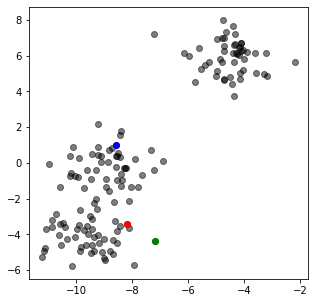

In [3]:
#определим центроиды, выбрав их случайно из точек выборки
np.random.seed(seed)
def init(k):
    centroids = data[np.random.choice(data.shape[0], size=k),:]
    return centroids

centroids = init(k)

#нарисуем выбранные центроиды
fig = plt.figure(figsize=(5, 5))
plt.scatter(data[:,0], data[:,1], color='k', alpha=0.5)
for i in range(k):
    plt.scatter(*centroids[i], color=colors[i+1])
plt.show()

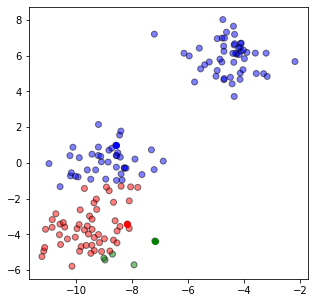

In [4]:
def assignment(data, centroids):
    distances = np.array([(data[:,0] - centr[0]) ** 2
                     + (data[:,1] - centr[1]) ** 2
                     for centr in centroids])
    labels = distances.argmin(axis=0)
    return labels

labels = assignment(data, centroids)

#нарисуем изначальное распределение по кластерам
fig = plt.figure(figsize=(5, 5))
plt.scatter(data[:,0], data[:,1], color=[colors[c+1] for c in labels],
            alpha=0.5, edgecolor='k')
for i in range(k):
    plt.scatter(*centroids[i], color=colors[i+1])
plt.show()

Видно, что центроиды выбраны не очень оптимально и первичное распределение слишком неправдоподобно. Но перейдем к следующему этапу алгоритма с надеждой, что итоговый результат будет лучше.

In [5]:
#реализуем функцию пересчёта центроидов
def update(centroids):
    for i,centr in enumerate(centroids):
        centr[0] = np.mean(data[labels == i][:, 0])
        centr[1] = np.mean(data[labels == i][:, 1])
    return centroids

Соберём весь процесс воедино и будем выполнять его до сходимости.

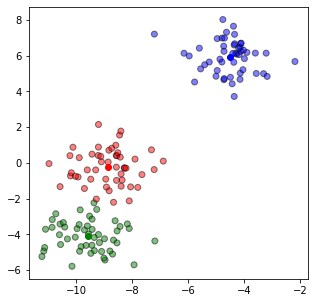

In [6]:
while True:
    old_centroids = centroids.copy()
    centroids = update(centroids)
    labels = assignment(data, centroids)
    if np.all(np.equal(old_centroids, centroids)):
        break

#нарисуем итоговое распределение точек по кластерам
fig = plt.figure(figsize=(5, 5))
plt.scatter(data[:,0], data[:,1], color=[colors[c+1] for c in labels],
            alpha=0.5, edgecolor='k')
for i in range(k):
    plt.scatter(*centroids[i], color=colors[i+1])
plt.show()

После сходимости распределение выглядит действительно правдоподобно, за исключением, возможно, некоторых точек на границе.
Сравним полученный результат с результатом алгоритма, встроенного в библотеку sklearn:

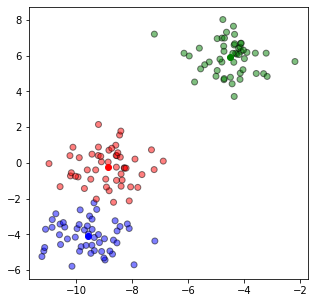

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k, init='random', random_state=seed)
kmeans.fit(data)

labels = kmeans.predict(data)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(5, 5))
plt.scatter(data[:,0], data[:,1], color=[colors[c+1] for c in labels],
            alpha=0.5, edgecolor='k')
for i, centr in enumerate(centroids):
    plt.scatter(*centr, color=colors[i+1])
plt.show()

Результаты совпадают (с точностью до цвета кластеров), что говорит о том, что алгоритм реализован правильно.

#### Промежуточные выводы о свойствах и проблемах k-means
1. k-means очень чувствителен к выбору начальных центров кластеров.
2. Оптимальное число кластеров необходимо выбирать самостоятельно.
3. Не гарантируется достижение глобального экстремума, алгоритм может "застрять" в какой-то локальной оптимальной точке (например по причине неудачного выбора начальных центроидов).

## Глава 2, в которой анализируется скорость алгоритма k-means:

Будем использовать готовую реализацию k-means в библиотеке sklearn с целью протестировать её на входных данных разного размера и сложности. Для оценки скорости сходимости будем измерять число итераций. Также будем измерять непосредственно время выполнения алгоритма, чтобы оценить насколько k-means "тормозит" на больших выборках. 
С точки зрения теории: алгоритмическая сложность каждой итерации алгоритма составляет O(nmk), где n - количество объектов, m - количество признаков,  k - число кластеров. При этом число итераций почти всегда больше одной, таким образом на больших выборках ожидается сильное замедление алгоритма. Перейдём непосредственно к тестам:

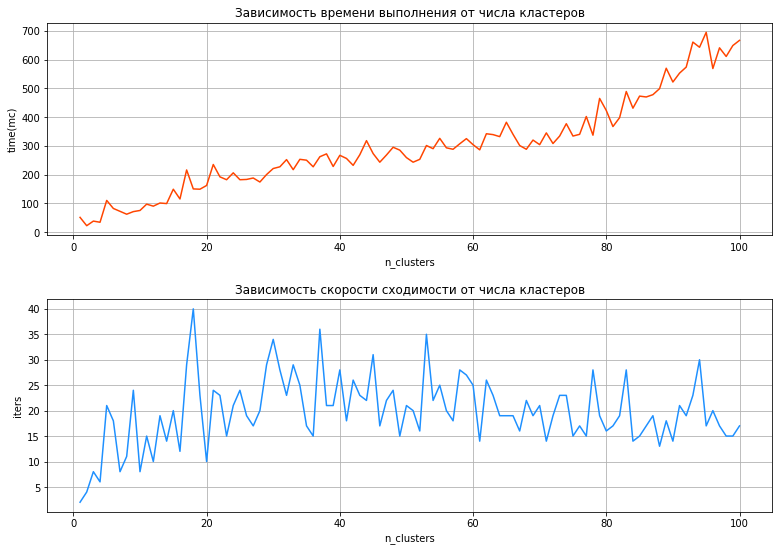

In [9]:
## Зависимость от числа кластеров
#импортируем библиотеку для измерения времени выполнения
import timeit

# протестируем на числе кластеров из отрезка [1,100] 
n_clusters = np.arange(1, 101)
n_samples = 1500
seed = 2019

timers = []
iters = []
for k in n_clusters:
    data, true_labels = make_blobs(n_samples=n_samples, n_features=2,
                         centers=k, random_state=seed)

    kmeans = KMeans(n_clusters=k, init='random', random_state=seed)

    start_time = timeit.default_timer()
    kmeans.fit(data)
    labels = kmeans.predict(data)
    timers.append(int((timeit.default_timer() - start_time) * 1000))
    iters.append(kmeans.n_iter_)
    
#нарисуем получившуюся зависимость
fig = plt.figure(figsize=(13, 9))
plt.subplots_adjust(hspace=0.3)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.set_title("Зависимость времени выполнения от числа кластеров")
ax1.set_xlabel("n_clusters")        
ax1.set_ylabel("time(mc)")
ax1.grid()
ax1.plot(n_clusters, timers, color='orangered')

ax2.set_title("Зависимость скорости сходимости от числа кластеров")
ax2.set_xlabel("n_clusters")        
ax2.set_ylabel("iters")
ax2.grid()
ax2.plot(n_clusters, iters, color='dodgerblue')

plt.show()

Из графиков видно, что с увеличением числа кластеров время выполнения увеличивается линейно. В то время как число итераций (скорость сходимости) практически не меняется. Можно сделать вывод, что от числа кластеров скорость сходимости не зависит. Теперь исследуем зависимость скорости выполнения/скорости сходимости от размера выборки.

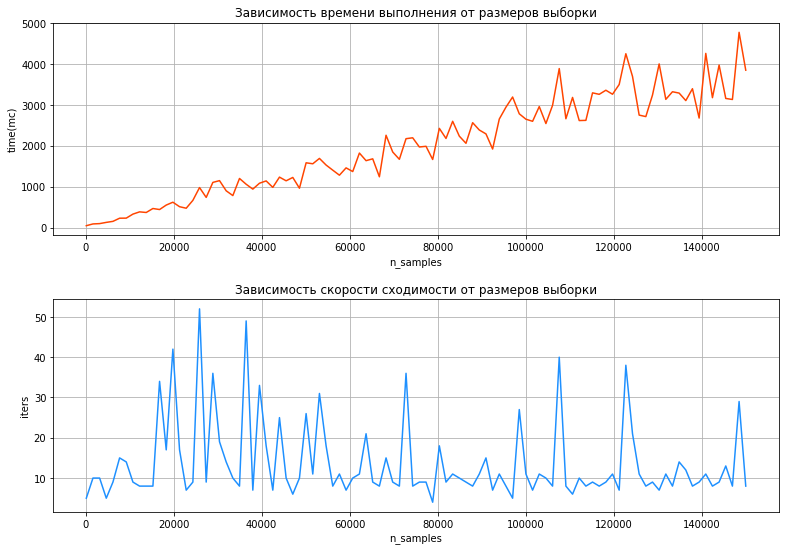

In [11]:
## Зависимость от размера выборки
# протестируем на 100 различных выборках взятых с равным шагом из диапазона [150,150000] 
n_samples = np.linspace(150, 150000, 100, dtype='int')
n_clusters = 5
seed = 2019

timers = []
iters = []
for n in n_samples:
    data, true_labels = make_blobs(n_samples=n, n_features=2,
                                   centers=n_clusters, random_state=seed)

    kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=seed)

    start_time = timeit.default_timer()
    kmeans.fit(data)
    labels = kmeans.predict(data)
    timers.append(int((timeit.default_timer() - start_time) * 1000))
    iters.append(kmeans.n_iter_)
    
#нарисуем получившуюся зависимость
fig = plt.figure(figsize=(13, 9))
plt.subplots_adjust(hspace=0.3)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.set_title("Зависимость времени выполнения от размеров выборки")
ax1.set_xlabel("n_samples")        
ax1.set_ylabel("time(mc)")
ax1.grid()
ax1.plot(n_samples, timers, color='orangered')

ax2.set_title("Зависимость скорости сходимости от размеров выборки")
ax2.set_xlabel("n_samples")        
ax2.set_ylabel("iters")
ax2.grid()
ax2.plot(n_samples, iters, color='dodgerblue')

plt.show()

Можно заметить, что и в этом случае число итераций (скорость сходимости) слабо зависит от размера выборки. В то время как время выполнения увеличивается так же линейно. Таким образом, и от размера выборки скорость сходимости не зависит.

#### Подведём краткие итоги:
1. Наблюдаемая скорость выполнения и её зависимость от числа кластеров/размера датасета совпадает с ожидаемой теоретической оценкой.
2. Скорость сходимости же, не зависит ни от числа кластеров, ни от размера датасета.
3. Алгоритм сходится довольно быстро: максимальное число итераций, которое потребовалось для сходимости ≈ 50

Смотря на графики, кажется что сходимость алгоритма зависит в большей степени от состава выборки: как именно объекты расположены относительно друг друга. Подтвердим или опровергнем эту гипотезу в следующей главе, исследуя k-means на выборках, разных по составу и внутреннему устройству.

## Глава 3, в которой говорится о задачах, для которых подходит k-means, и о задачах, где его лучше не использовать.

Для начала, так как мы используем понятие расстояния в алгоритме, то это значит, что на множестве признаков должна быть задана какая то адекватная метрика. Поэтому, в случае если признаки (или их большая часть) категориальные, то k-means явно не лучший выбор.
Алгоритм хорошо работает, когда объекты чётко разделимы: образуют компактные сгустки, растояния между которыми велико. В обратном случае алгоритм k-means зачастую дает неправдоподобное разделение на кластеры, как например если один кластер вложен в другой или кластеры имеют форму линий. Это происходит из-за того, что минимизируя расстояние от точек до центроида кластера, мы неявно делаем предположение, что кластеры имеют форму "шара". Также k-means не подходит для случая, когда один из соседних кластеров намного больше другого. Перейдем к примерам, подтверждающим сформулированные выше идеи:

1: 20 итераций
2: 7 итераций
3: 27 итераций
4: 4 итераций
5: 6 итераций
6: 12 итераций
7: 7 итераций


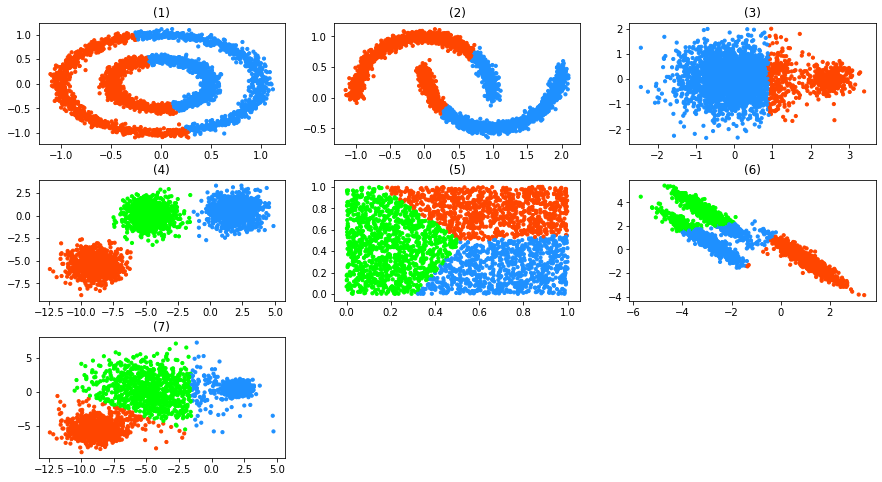

In [5]:
## Рассмотрим примеры
from sklearn import datasets

seed = 170
n_samples = 3000
np.random.seed(seed)

#сгенерируем несколько датасетов

# концетрические окружности
circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                noise=.05, random_state=seed)
# полумесяцы
moons = datasets.make_moons(n_samples=n_samples, noise=.05,
                                random_state=seed)
# хорошо разделенные кучки точек
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)

# полностью заполненный квадрат
full = np.random.rand(n_samples, 2),None

# 2 кластера разных размеров
two_spheres = datasets.make_blobs(n_samples=[2700, 300],
                          centers=[(0.0,0.0),(2.5,0.0)],
                          cluster_std=[0.7, .3],random_state=seed)

# кучки-линии
X, y = datasets.make_blobs(n_samples=n_samples, random_state=seed)
transform = [[0.6, -0.6], [-0.4, 0.8]]
X_linear = np.dot(X, transform)
linear = (X_linear, y)

# кучки разной степени "скученности"
varied = datasets.make_blobs(n_samples=n_samples,
                               cluster_std=[1.0, 2.5, 0.5],
                               random_state=seed)

datasets = [circles, moons, two_spheres, blobs, full, linear, varied]
n_clusters = [2, 2, 2, 3, 3, 3, 3]

# зафиксируем цвета кластеров и подготовим графики
colors = {1: 'dodgerblue', 2: 'orangered', 3: 'lime'}
fig = plt.figure(figsize=(15,8))
plt.subplots_adjust(hspace=0.3)
axes = [fig.add_subplot(x) for x in range(331, 338)]

# применим Kmeans к каждому датасету и нарисуем результат
for i,tmp in enumerate(datasets):
    X, y = tmp
    kmeans = KMeans(n_clusters=n_clusters.pop(0), init='random', random_state=seed)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    axe = axes.pop(0)
    axe.set_title(f"({i+1})")
    axe.scatter(X[:, 0], X[:, 1], s=10, color=[colors[x + 1] for x in labels])
    
    # будем выводить также число итераций для каждого датасета
    print(f"{i+1}: {kmeans.n_iter_} итераций")

plt.show()

Видно, что на выборках вида (1), (2), (6), где кластеры "не-шары", алгоритм k-means работает недопустимо плохо. В то же время на (4), (7), где кластеры "шары", алгоритм работает намного лучше (результаты хотя бы отчасти правдоподобны). При этом лучшая кластеризация достигается на выборке (4), как и ожидалось. Из результата на выборке (5) становится понятна ещё одна особенность k-means - кластеры получаются сбалансированными по числу объектов. Проблема двух кластеров разного размера отражена на выборке (3) - видно, что меньший кластер "отщепляет" часть данных от кластера-соседа большего размера.

Заметим также, что гипотеза, сформулированная в конце предыдущей главы, подтверждается. Число кластеров, число объектов, число признаков у датасетов совпадает. Однако, число итераций на некоторых выборках намного больше, чем на других. Таким образом, скорость сходимости в большей степени определяется именно внутренним устройством выборки, а не её размером или числом кластеров.

#### Суммируя все наблюдения:
k-means хорош, когда:
1. Кластеры - "шары".
2. Кластеры чётко разделимы (расстояния между центрами велико).
3. Кластеры имеют приблизительно одинаковое число объектов.

k-means плох, когда:
1. Кластеры - "не-шары".
2. Кластеры смешаны (расстояние между центрами мало/сравнимо с расстоянием между объектами одного кластера).
3. Кластеры не сбалансированы по числу объектов: один явно больше других.

Таким образом, для успешного применения алгоритма требуется дополнительная информация о выборке и предварительная обработка данных, что сокращает спектр задач, в которых применим k-means, и делает этот алгоритм менее универсальным. В этом случае единственным существенным "плюсом" алгоритма остается его простота.

## Глава 4, в которой исследуется стратегия выбора начального приближения.

Как было сказано в конце главы 1, k-means сильно чувствителен к выбору начальных центров кластеров. Попробуем показать это, а также рассмотреть методы устранения этого недостатка. Рассмотрим следующий пример:

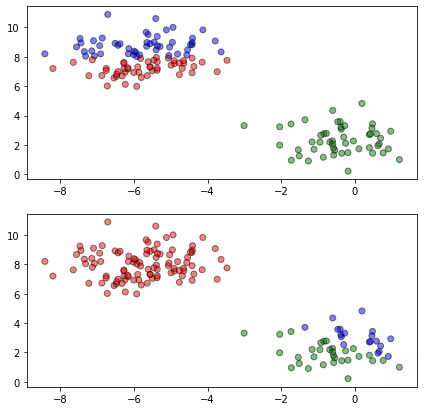

In [276]:
#пример результата с разными начальными приближениями
seed = 5

#создадим датасет и выберем число кластеров
X, y = make_blobs(n_samples=150, n_features=2,
                         centers=3, random_state=seed)
k = 3

# используем Kmeans на данных с аргументами init='random', n_init=1
kmeans1 = KMeans(n_clusters=k, init='random', n_init=1, random_state=seed)
kmeans1.fit(X)

labels1 = kmeans1.predict(X)

# применим Kmeans ещё раз, но с другим значением random_state
seed += 1
kmeans2 = KMeans(n_clusters=k, init='random', n_init=1, random_state=seed)
kmeans2.fit(X)

labels2 = kmeans2.predict(X)

# отобразим результаты и сравним
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.scatter(X[:,0], X[:,1], color=[colors[c+1] for c in labels1],
            alpha=0.5, edgecolor='k')
ax2.scatter(X[:,0], X[:,1], color=[colors[c+1] for c in labels2],
            alpha=0.5, edgecolor='k')

plt.show()

Легко видеть, что результаты отличаются, при том существенно. В первом случае ещё можно говорить о правдоподобном разделении на кластеры, но второй результат очевидно ошибочен. Именно в этом и заключается проблема выбора начального приближения для алгоритма k-means. Решение приходит простое: запускать алгоритм несколько раз, используя разные случайные начальные значения, а потом брать лучший результат среди всех запусков. Именно так и работает Kmeans в библиотеке sklearn (за это отвечает параметр n_init, который мы установили равным 1). Проверим на прошлом примере, что многократный запуск действительно решает проблему начального приближения:

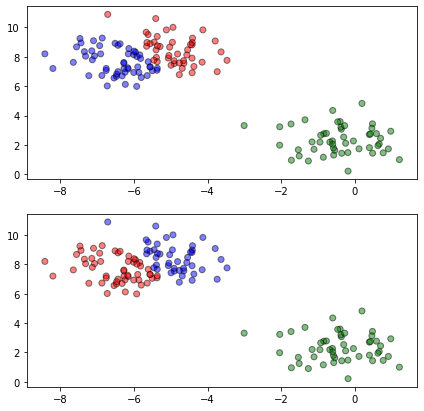

In [278]:
#пример сходимости за счёт многократного числа инициализаций

# используем Kmeans с аргументами init='random', n_init=10
seed = 5
new_kmeans1 = KMeans(n_clusters=k, init='random', n_init=10, random_state=seed)
new_kmeans1.fit(X)

labels1 = new_kmeans1.predict(X)

# применим Kmeans ещё раз, но с другим значением random_state
seed += 1
new_kmeans2 = KMeans(n_clusters=k, init='random', n_init=10, random_state=seed)
new_kmeans2.fit(X)

labels2 = new_kmeans2.predict(X)

# нарисуем результаты и сравним
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.scatter(X[:,0], X[:,1], color=[colors[c+1] for c in labels1],
            alpha=0.5, edgecolor='k')
ax2.scatter(X[:,0], X[:,1], color=[colors[c+1] for c in labels2],
            alpha=0.5, edgecolor='k')

plt.show()

Видно, что результаты совпадают с точностью до цвета. Таким образом, многократная инициализация случайными значениями с последующим отбором лучшего результата, в Kmeans для этого используется значение инерции (аттрибут inertia_), действительно является простой и эффективной стратегией выбора начального приближения. Кроме этого способа существуют и другие, основанные на эвристике, например метод, реализованный в k-means++.

In [6]:
# Для использования k-means++ метода необходимо просто запустить Kmeans c параметром init='k-means++'

## Глава 5, в которой исследуется выбор оптимального числа кластеров.

Чтобы говорить об оптимальности или неоптимальности чего-либо, сначала необходимо определить, как именно эта "оптимальность" будет измеряться. 
В случае k-means логично в качестве метрики качества кластеризации использовать инерцию - сумму квадратов расстояний от точек до центроидов кластеров, к которым они относятся. Логично, потому что Kmeans, реализованный в sklearn, считает эту инерцию и позволяет нам работать с ней. Ещё одна причина в пользу использования инерции - минимизация инерции это ровно то, что мы хотим: точки кластера находятся близко к центроиду. 
Однако, понятно что минимум инерции достигается в случае, когда число кластеров равно числу объектов (каждый в своём кластере), а это явно не оптимальный выбор. Поэтому, будем искать такое число кластеров, начиная с которого инерция почти не изменяется - "точку перелома". 

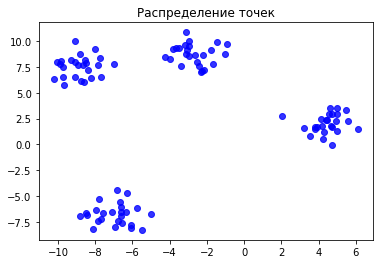

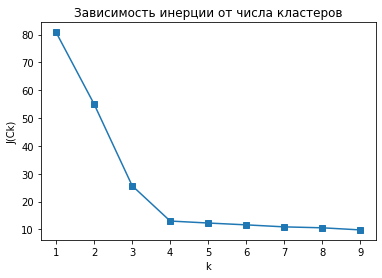

In [68]:
## Рассмотрим пример

# выберем seed и зафиксируем истинное число кластеров
seed_1 = 42 
true_k = 4

#создадим датасет X
X, y = make_blobs(n_samples=100, n_features=2,
                         centers=true_k, random_state=seed_1)

# вычислим инерцию для каждого числа кластеров
inertias = []
for k in range(1, X.shape[0]):
    clr = KMeans(n_clusters=k, init='random', random_state=seed_1).fit(X)
    inertias.append(np.sqrt(clr.inertia_))

plt.title("Распределение точек")
plt.scatter(X[:,0],X[:,1], color='b', alpha=0.8)
plt.show()

plt.title("Зависимость инерции от числа кластеров")
plt.plot(range(1, 10), inertias[:9], marker='s');
plt.xlabel('k')
plt.ylabel('J(Ck)')
plt.show()

На графике выше видно, что при k < 4 значение инерции резко убывает, а при k > 4 значение инерции почти не меняется. Таким образом имеем в точке k = 4 искомый "перелом". Заметим, что при этом оптимальное значение кластеров для выборки действительно равно 4: по построению и как видно из графика распределения точек.

## Глава 6, в которой исследуется эвристика для визуализации матрицы попарных расстояний

Матрица попарных расстояний -  матрица размером (n,n), где n - число объектов в выборке, при этом элемент с индексами (i,j) равен евклидову расстоянию между объектами с номерами i и j. Очевидно, что матрица симметрична, её элементы неотрицательны и равны нулю на главной диагонали и только на ней. Рассмотрим пример, на котором покажем, как кластеризация влияет на матрицу попарных расстояний.

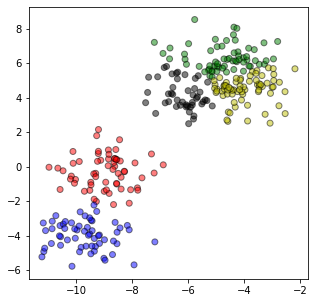

In [246]:
# создадим датасет
seed = 1984
k = 5
X, y = make_blobs(n_samples=300, n_features=2,
                         centers=k, random_state=seed)

# применим Kmeans на данном наборе данных
kmeans = KMeans(n_clusters=k, init='random', random_state=seed)
kmeans.fit(X)

labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_

# нарисуем получившийся результат
colors = {1: "r", 2: "g", 3: "b", 4: "y", 5: "k"}
fig = plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], color=[colors[c+1] for c in labels],
            alpha=0.5, edgecolor='k')
plt.show()

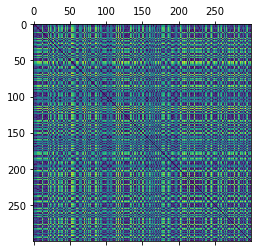

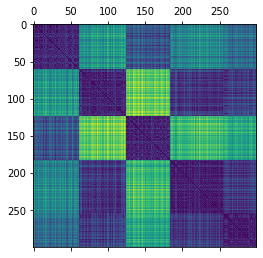

In [247]:
# нарисуем матрицу попарных расстояний
from scipy.spatial.distance import cdist, pdist, squareform, euclidean

# до кластеризации
matrix = cdist(X, X)
plt.matshow(matrix, fignum=0)

# после кластеризации
order = [x[0] for x in sorted(enumerate(labels), key=lambda x: x[1])]
X_sort = X[order]
matrix_sort = cdist(X_sort, X_sort)
plt.matshow(matrix_sort)

plt.show()

Видно, что до кластеризации матрица неупорядочена и хаотична. После кластеризации виден некоторый шум, однако данные приобретают упорядоченность. На главной диагонале видны темные квадратные области - кластеры. Но применим некоторые дополнительные преобразования, которые возможно приведут к большей упорядоченности. 
В предположении, что число кластеров много меньше числа объектов, построим матрицу попарных расстояний для них. Расстоянием между кластерами будем считать евклидово расстояние между центроидами этих кластеров. Начиная с произвольного кластера, обойдем все, каждый раз переходя в кластер, расстояние до которого минимально. Будем перебирать все кластеры, в качестве первоначального, и считать суммарное "пройденное" расстояние. Выберем путь обхода, соответствующий максимальному "пройденному" расстоянию, так как хотим, чтобы центры кластеров были далеко друг от друга. Внутри каждого кластера упорядочим точки в порядке возрастания расстояния от центра масс центроидов кластеров. Получим следующий резельтат:

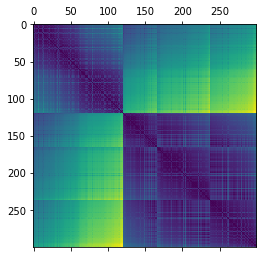

In [248]:
# после дополнительных преобразований
centr_matrix = squareform(pdist(centroids))
centr = [np.mean(centroids[:, 0]), 
         np.mean(centroids[:, 1])]
scores = [0]*len(centroids)
for i in range(len(centroids)):
    X[labels == i] = sorted(X[labels == i], key=lambda x: np.linalg.norm(x - centr))
    centr_order = [i,]
    score = 0
    tmp = i
    tmp_matrix = centr_matrix.copy()
    for _ in range(tmp_matrix.shape[0]-1):
        tmp_matrix[:, tmp] = np.inf
        j = np.argmin(tmp_matrix[tmp,:])
        score += tmp_matrix[tmp, j]
        tmp_matrix[tmp, :] = np.inf
        centr_order.append(j)
        tmp = j
    scores[i] = (score, centr_order)

centr_order = max(scores, key=lambda x: x[0])[1]

order = [x[0] for x in sorted(enumerate(labels), 
                                     key=lambda x: centr_order.index(x[1]))]
X_sort = X[order]
matrix_sort = cdist(X_sort, X_sort)
plt.matshow(matrix_sort)

plt.show()

Видно, что теперь матрица попарных расстояний выглядит действительно упорядоченно, кроме того: деление на кластеры по прежнему остается. Также из матрицы можно извлечь дополнительную информацию: последние три кластера возможно стоило бы объединить в один большой, так как они достаточно близки друг к другу и при этом удалены от оставшихся двух кластеров. Таким образом, можно считать, что предложенный алгоритм действительно улучшает визуализацию матрицы попарных расстояний. 

## Глава 7, вместо заключения.

#### Такой себе отчёт получился, если честно.